## Importing Data

In [15]:
import os
path = r'../input/hindi-speech-classification/dataset'

In [16]:
import librosa
import pandas as pd
import numpy as np

In [17]:
train = pd.read_csv(os.path.join(path, 'train.csv'))
test = pd.read_csv(os.path.join(path, 'test.csv'))

In [18]:
train.head()

,file_id,gender
0,common_voice_hi_26204093,male
1,common_voice_hi_26043935,male
2,common_voice_hi_24632150,male
3,common_voice_hi_24359471,female
4,common_voice_hi_24639127,male


In [19]:
train['file_id'] = pd.DataFrame(train['file_id'].apply(lambda x: os.path.join(path, 'train/{}.mp3'.format(x))))
test['file_id'] = pd.DataFrame(test['file_id'].apply(lambda x: os.path.join(path, 'test/{}.mp3'.format(x))))

## Extracting Zero Cross Rating Features

In [20]:
def ZCR_features(data):
    zcrs = []
    try:
        x , sr = librosa.load(data, res_type='kaiser_fast')
        zcrs = librosa.feature.zero_crossing_rate(x)[0]
    except:
        print('Error reading audio')
    return zcrs

In [21]:
from tqdm.notebook import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings("ignore")

In [22]:
#Extracting zero-cross rating features
X_train = pd.DataFrame(train['file_id'].progress_apply(lambda x: ZCR_features(x)).tolist())
X_test = pd.DataFrame(test['file_id'].progress_apply(lambda x: ZCR_features(x)).tolist())

  0%|          | 0/1998 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

## Imputing null values

In [23]:
X_train.isna().sum()

0         0
1         0
2         0
3         0
4         0
       ... 
434    1996
435    1996
436    1996
437    1996
438    1997
Length: 439, dtype: int64

### Imputing with mean

In [24]:
X_train_zero = X_train.copy()

In [25]:
X_train_zero.fillna(value=0, inplace=True)

### Imputing with KNNImputer

In [26]:
from sklearn.impute import KNNImputer

In [27]:
imputer = KNNImputer(n_neighbors=2)
X_train_knni = imputer.fit_transform(X_train.copy())

## PCA

In [28]:
from sklearn.decomposition import PCA

### Applying PCA on zero impute and generating the clusters using KMeans

In [29]:
pca = PCA()
X_train_zero_pca = pca.fit_transform(X_train_zero)
X_train_zero_pca = pd.DataFrame(X_train_zero_pca )
#X_train_zero_pca.head()

In [30]:
from sklearn.cluster import KMeans

In [31]:
from tqdm import tqdm
import plotly as py
import plotly.graph_objs as go
from sklearn.metrics import silhouette_score

In [32]:
def kmean(train):
    opt_val = []
    for i in tqdm(range(1, 13)):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        kmeans.fit(train.iloc[:,:3])
        opt_val.append(kmeans.inertia_)
    plt.figure(figsize=(10,5))
    sns.lineplot(range(1, 13), opt_val, marker='o',color='red')
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Optimal Value')
    plt.show()
    cluster = int(input("Enter number of clusters: "))
    kmean_visualization(train, cluster)
def kmean_visualization(train, cluster):
    kmeans = KMeans(n_clusters = cluster, init = 'k-means++', random_state = 42)
    kmeans.fit(train.iloc[:,:3])
    y_kmeans = kmeans.fit_predict(train.iloc[:, :3])
    trace1 = go.Scatter3d(x= train[0],
                          y= train[1],
                          z= train[2],
                          mode='markers',
                          marker=dict(color = y_kmeans,size= 10,line=dict(color= y_kmeans,width= 12),opacity=0.8))
    data_plotly = [trace1]
    layout = go.Layout(title= 'Clusters wrt three PCA Components',
                       scene = dict(xaxis = dict(title  = 'PCA 0'),
                                    yaxis = dict(title  = 'PCA 1'),
                                    zaxis = dict(title  = 'PCA 2')))
    fig = go.Figure(data=data_plotly, layout=layout)
    fig.show()
    print("Silhouette Score: ",silhouette_score(train.iloc[:,:3], y_kmeans))

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

100%|██████████| 12/12 [00:01<00:00,  6.75it/s]


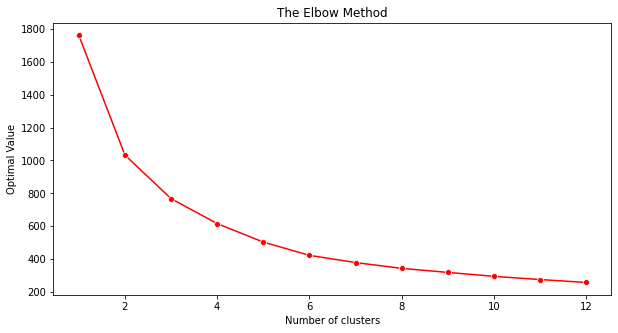

Enter number of clusters:  3


Silhouette Score:  0.4315539976321115


In [34]:
kmean(X_train_zero_pca)

### T-SNE on zero impute with KMeans

In [35]:
from sklearn.manifold import TSNE

In [36]:
tsne = TSNE(n_components=3, learning_rate='auto',init='random', perplexity=3)
X_train_zero_tsne = tsne.fit_transform(X_train_zero.iloc[:,:3])

kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
kmeans.fit(X_train_zero_tsne)
y_kmeans = kmeans.fit_predict(X_train_zero_tsne)
print("Silhouette Score: ",silhouette_score(X_train_zero_tsne, y_kmeans))

Silhouette Score:  0.28377506


### PCA on KNN imputation with KMeans, Agglomerative, DBSCAN, and mean shift

#### KMeans

In [37]:
pca = PCA()
X_train_knni_pca = pca.fit_transform(X_train_knni)
X_train_knni_pca = pd.DataFrame(X_train_knni_pca )
#X_train_zero_pca.head()

100%|██████████| 12/12 [00:01<00:00,  7.95it/s]


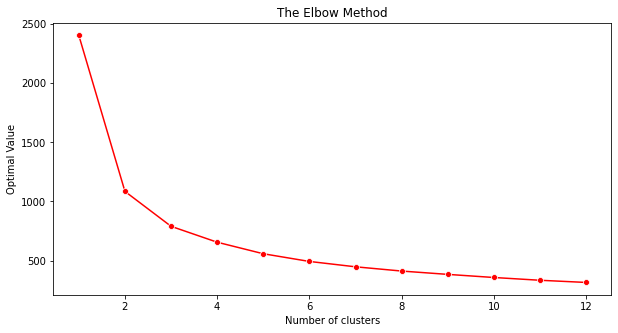

Enter number of clusters:  3


Silhouette Score:  0.41401768192572985


In [38]:
kmean(X_train_knni_pca)

#### Agglomerative

In [39]:
from scipy.cluster import hierarchy

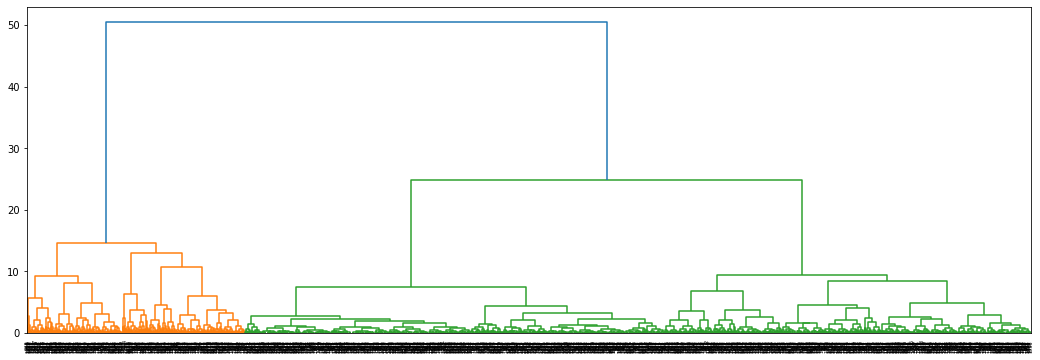

In [40]:
plt.figure(figsize=(18,6))
dn = hierarchy.dendrogram(Z = hierarchy.linkage(X_train_knni_pca.iloc[:,:3], 'ward'))

In [41]:
from sklearn.cluster import AgglomerativeClustering

In [42]:
agglo_cluster = AgglomerativeClustering(n_clusters=3).fit(X_train_knni_pca.iloc[:,:3])
y_label = agglo_cluster.labels_

In [43]:
print("Silhouette Score: ",silhouette_score(X_train_knni_pca.iloc[:,:3], y_label))

Silhouette Score:  0.3896986623226331


#### DBSCAN

In [44]:
from sklearn.cluster import DBSCAN

In [45]:
db = DBSCAN(eps=0.4, min_samples=20)
db.fit(X_train_knni_pca.iloc[:,:3])

DBSCAN(eps=0.4, min_samples=20)

In [46]:
y_pred = db.fit_predict(X_train_knni_pca.iloc[:,:3])
print("Silhouette Score: ",silhouette_score(X_train_knni_pca.iloc[:,:3], y_pred))

Silhouette Score:  0.5243788185464507


#### mean shift

In [47]:
from sklearn.cluster import MeanShift
from mpl_toolkits.mplot3d import Axes3D

In [49]:
ms = MeanShift().fit(X_train_knni_pca.iloc[:,:3])
y_label = ms.labels_
print("Silhouette Score: ",silhouette_score(X_train_knni_pca.iloc[:,:3], y_label))

Silhouette Score:  0.47848760314027283


## Results  
<table>
<tr> <td> Imputation </td> <td> Method </td> <td> Silhouette Score </td> </tr> 
<tr> <td> Zero </td> <td> KMeans </td> <td> 0.43 </td> </tr>
<tr> <td> Zero </td> <td> T-SNE </td> <td> 0.26 </td> </tr>
<tr> <td> KNNImputer </td> <td> KMeans </td> <td> 0.41 </td> </tr> 
<tr> <td> KNNImputer </td> <td> Agglomerative </td> <td> 0.38 </td> </tr> 
<tr> <td> KNNImputer </td> <td> DBSCAN </td> <td> 0.52 </td>  </tr>
<tr> <td> KNNImputer </td> <td> Mean Shift </td> <td> 0.47 </td>  </tr>
</table>
Clustering with KNNImputer and DBSCAN has the heighest Silhouette Score which means that this method could distinguish between the clusters better.